# Import data and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, accuracy_score

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import scripts

# constants and settings
rand_seed = 35

2025-11-18 21:55:42.444382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data
tree_data = pd.read_csv('../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())

In [3]:
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(f"Dataset shape: {tree_data.shape}")

Nan values in dataset: 0
Dataset shape: (581012, 55)


# Data exploration

In [4]:
tree_reduced = scripts.sample_stratify(tree_data, 'Cover_Type', n_samples=100000, rand_state=rand_seed)
X_tree, y_tree = tree_reduced.drop(columns=['Cover_Type']), tree_reduced['Cover_Type']
y_tree -= 1  # make labels zero-indexed

Very uneven label distribution, mostly centered on types 1 and 2.
Stratified sampling require to ensure labels 3-7 are properly represented in training.

In [5]:
# std_scaler, x_st_scale = scripts.normalize_data(X_tree, method='standard')
scaler = preproc.StandardScaler()
x_st_scale = scaler.fit_transform(X_tree)

## Split training/testing data

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_st_scale, y_tree, test_size=0.2, stratify=y_tree, random_state=rand_seed)
print("Training counts before resampling:")
print(y_train.value_counts())

Training counts before resampling:
Cover_Type
1    39008
0    29168
2     4923
6     2824
5     2391
4     1307
3      379
Name: count, dtype: int64


In [7]:
# target_over = {3: 1000, 4: 1000, 5: 1000, 6: 1000}
target_over = {3: 1000}
# target_under = {0: 1000, 1: 1000, 2: 1000}
target_under = {0: 6000, 1: 6000}

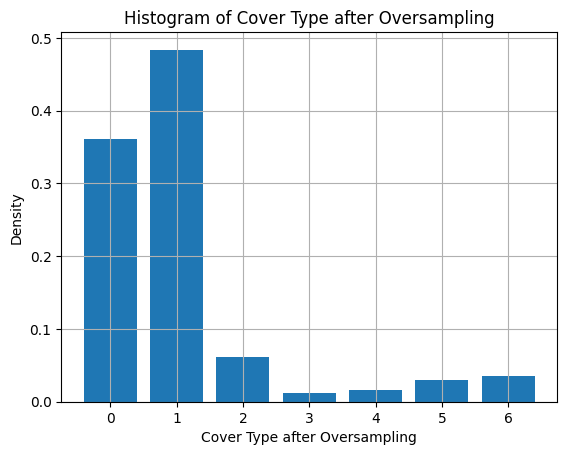

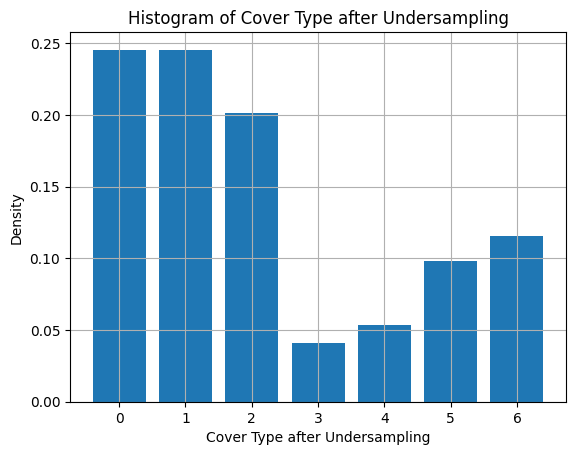

In [8]:
# Oversample minority categories
x_resample, y_resample = SMOTE(random_state=rand_seed, sampling_strategy=target_over, k_neighbors=2).fit_resample(x_train, y_train)
scripts.plot_histogram(y_resample, label='Cover Type after Oversampling')

# Undersample majority categories
x_resample, y_resample = RandomUnderSampler(random_state=rand_seed, sampling_strategy=target_under).fit_resample(x_resample, y_resample)
scripts.plot_histogram(y_resample, label='Cover Type after Undersampling')

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=rand_seed)


# Perceptron model training

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

scripts.MLPModel

mlp = scripts.MLPModel(input_dim=x_train.shape[1], 
                         num_classes=len(y_tree.unique()),
                         learning_rate=1e-4)

mlp.set_train(x_train, y_train)
mlp.set_val(x_val, y_val)
mlp.set_test(x_test, y_test)

In [15]:
mlp.build_model()
mlp.overview()

/home/alex/Class/CSCI635/CSCI-635-1-Group-5/venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,671 (319.03 KB)

 Trainable params: 81,671 (319.03 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = mlp.train(epochs=400, callbacks=[es], verbose=1)

Epoch 1/400


2025-11-18 21:57:48.274935: I external/local_xla/xla/service/service.cc:163] XLA service 0x76b780005180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-18 21:57:48.274946: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-11-18 21:57:48.289442: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-18 21:57:48.382376: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3748 - loss: 1.7670 

I0000 00:00:1763521068.977099   75487 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5059 - loss: 1.4515 - val_accuracy: 0.6053 - val_loss: 1.1237
Epoch 2/400
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6397 - loss: 0.9919 - val_accuracy: 0.6657 - val_loss: 0.8795
Epoch 3/400
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6718 - loss: 0.8272 - val_accuracy: 0.6874 - val_loss: 0.7729
Epoch 4/400
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6937 - loss: 0.7498 - val_accuracy: 0.7086 - val_loss: 0.7197
Epoch 5/400
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7114 - loss: 0.7084 - val_accuracy: 0.7219 - val_loss: 0.6886
Epoch 6/400
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7219 - loss: 0.6823 - val_accuracy: 0.7283 - val_loss: 0.6682
Epoch 7/400
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7268 - loss: 0.6643 - val_accuracy: 0.7327 - val_loss: 0.6531
Epoch 8/400
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7312 - loss: 0.6507 - val_accuracy: 0.7361 - val_loss: 0.

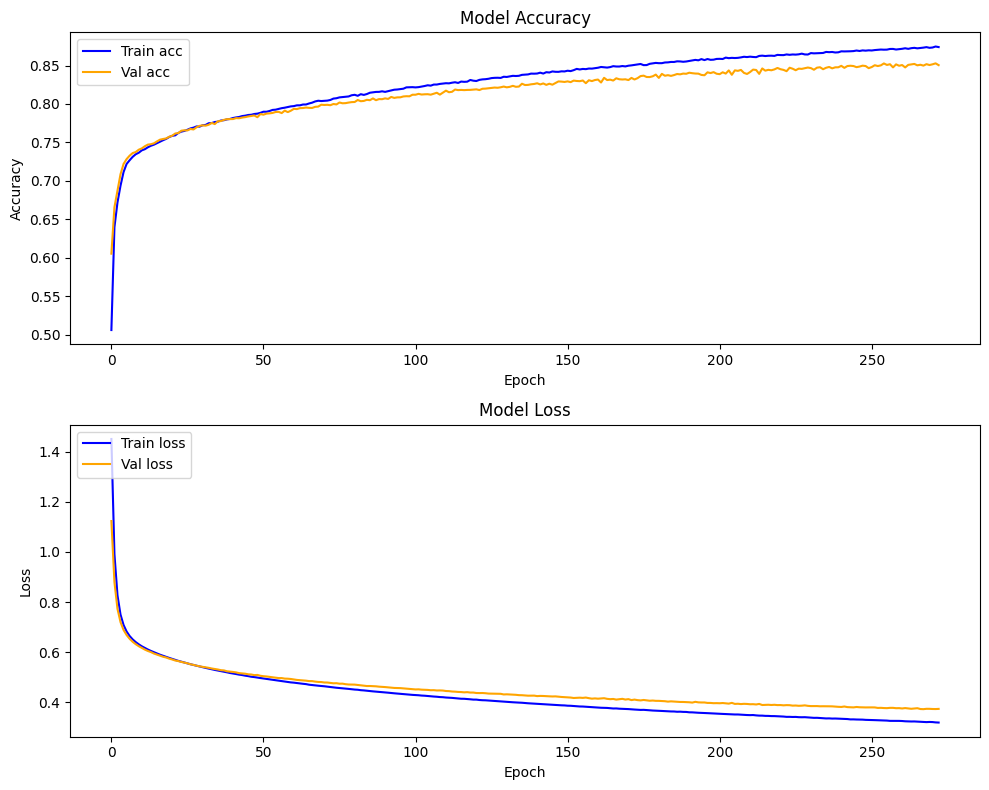

In [18]:
mlp.visualize_history(history)

In [21]:
test_loss, test_acc = mlp.evaluate()
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
mcc, conf, class_report = mlp.evaluate(
    metrics=[matthews_corrcoef, confusion_matrix, classification_report]
)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print("Confusion Matrix:\n", conf)
print("Classification Report:\n", class_report)

Test Loss: 0.4006, Test Accuracy: 0.8422
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
Matthews Correlation Coefficient: 0.7445
Confusion Matrix:
 [[5981 1228    0    0    3    2   78]
 [ 869 8704   71    0   32   62   14]
 [   2   97 1048   10    1   73    0]
 [   0    0   30   60    0    4    0]
 [  23  162    7    0  134    1    0]
 [   0   75  191    4    0  328    0]
 [ 106   11    0    0    0    0  589]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      7292
           1       0.85      0.89      0.87      9752
           2       0.78      0.85      0.81      1231
           3       0.81      0.64      0.71        94
           4       0.79      0.41      0.54       327
           5       0.70      0.55      0.61       598
           6       0.86      0.83      0.85       706

    accuracy                           0.84     20000
   macro avg       0.81      0.71      0.75     20000
weighted avg       0.84